In [1]:
import torch
from slice_inflate.datasets.clinical_cardiac_views import replace_sp_tensor_values, get_sub_sp_tensor, display_clinical_views, get_clinical_cardiac_view_affines
from slice_inflate.utils.nifti_utils import nifti_grid_sample
from matplotlib import pyplot as plt
import nibabel as nib

In [2]:
def get_clinical_views(volume:torch.Tensor, sp_label:torch.Tensor, volume_affine:torch.Tensor,
                           clinical_view_affines: dict, output_to_file=None):
    assert volume.dim() == 3
    assert sp_label.dim() == 3
    assert sp_label.is_sparse

    fov_mm = torch.tensor([192.,192.,1.])
    fov_vox = torch.tensor([128,128,1])

    # fig, axs = plt.subplots(len(clinical_view_affines)//5+1, 5)
    # axs = axs.flatten()

    # for ax in axs:
    #     ax.axis('off')

    # for ax, (view_name, pt_affine) in zip(axs, clinical_view_affines.items()):

    ret_dict = {}
    for view_name, pt_affine in clinical_view_affines.items():

        image_slice, *_ = nifti_grid_sample(volume[None,None], volume_affine[None], None, fov_mm, fov_vox,
            is_label=False, pre_grid_sample_affine=pt_affine[None], pre_grid_sample_hidden_affine=None, dtype=torch.float32
        )
        label_slice, *_ = nifti_grid_sample(sp_label.to_dense()[None,None], volume_affine[None], None, fov_mm, fov_vox,
            is_label=True, pre_grid_sample_affine=pt_affine[None], pre_grid_sample_hidden_affine=None, dtype=torch.float32
        )
        ret_dict[view_name] = (image_slice[0,0,...,0].T.flip(0), label_slice[0,0,...,0].T.flip(0))
        # ax.imshow(image_slice[0,0,...,0].T.flip(0), cmap='gray')
        # ax.imshow(label_slice[0,0,...,0].T.flip(0), cmap='magma', alpha=.2, interpolation='none',
        #           vmin=0, vmax=sp_label.to_dense().max())
        # ax.set_title(view_name)
        # ax.axis('off')
    # plt.subplots_adjust(left=0.2, right=.8, top=1.2)
    # if output_to_file is not None:
    #     fig.savefig(output_to_file, bbox_inches="tight")
    # else:
    #     plt.show()
    # plt.close()
    return ret_dict

In [3]:
NUM_SA_SLICES = 3

class_dict = dict(
    MYO=1,
    LV=2,
    RV=3,
    LA=4,
    RA=5
)

mrxcat_label = "/home/weihsbach/storage/staff/christianweihsbach/slice_inflate/data/datasets/MRXCAT/prepared_files/phantom_001/phantom_001_t000_label.nii.gz"
mrxcat_image = "/home/weihsbach/storage/staff/christianweihsbach/slice_inflate/data/datasets/MRXCAT/prepared_files/phantom_001/phantom_001_t000_image.nii.gz"

nii = nib.load(mrxcat_image)
nii_image = torch.as_tensor(nii.get_fdata())
nii_affine = torch.as_tensor(nii.affine)
sp_nii_label = torch.as_tensor(nib.load(mrxcat_label).get_fdata().astype(int)).to_sparse()

clinical_view_affines = get_clinical_cardiac_view_affines(
    sp_nii_label, nii_affine, class_dict, num_sa_slices=NUM_SA_SLICES, debug=False,
    return_unrolled=True
)

del clinical_view_affines['SA-0']
del clinical_view_affines['SA-2']

mrxcat_views = get_clinical_views(nii_image, sp_nii_label.to_sparse(), nii_affine,
    clinical_view_affines)

In [4]:
mmwhs_label = "/home/weihsbach/storage/staff/christianweihsbach/slice_inflate/data/datasets/MMWHS/prepared_files/mr_train_1009_label.nii.gz"
mmwhs_image = "/home/weihsbach/storage/staff/christianweihsbach/slice_inflate/data/datasets/MMWHS/prepared_files/mr_train_1009_image.nii.gz"

nii = nib.load(mmwhs_image)
nii_image = torch.as_tensor(nii.get_fdata())
nii_affine = torch.as_tensor(nii.affine)
sp_nii_label = torch.as_tensor(nib.load(mmwhs_label).get_fdata().astype(int)).to_sparse()

clinical_view_affines = get_clinical_cardiac_view_affines(
    sp_nii_label, nii_affine, class_dict, num_sa_slices=NUM_SA_SLICES, debug=False,
    return_unrolled=True
)

del clinical_view_affines['SA-0']
del clinical_view_affines['SA-2']

mmwhs_views = get_clinical_views(nii_image, sp_nii_label.to_sparse(), nii_affine,
    clinical_view_affines)

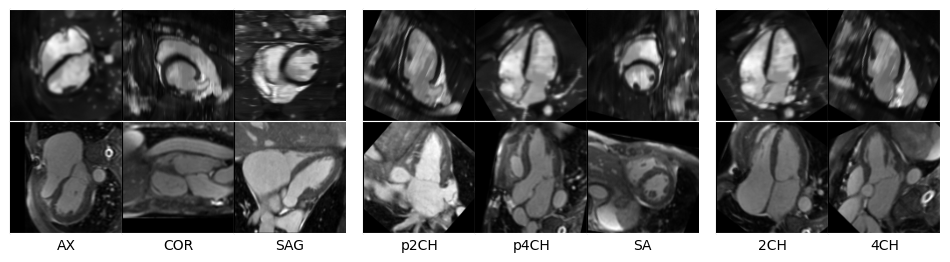

In [5]:
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid
import matplotlib

GROUP_SIZE = 8
num_labels = 5

img_list = [vw[0] for vw in list(mrxcat_views.values()) + list(mmwhs_views.values())]
label_list = [vw[1] for vw in  list(mrxcat_views.values()) + list(mmwhs_views.values())]

cmap_hi_r = matplotlib.colormaps['magma']

fig = plt.figure(figsize=(12, 6))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(len(label_list)//GROUP_SIZE, GROUP_SIZE),
                 axes_pad=0.0,
                 label_mode="L",
                 )

gts = []
for gt in label_list[::GROUP_SIZE]:
    gts.extend([gt.clone()] * GROUP_SIZE)

for idx, (ax, im, lbl) in enumerate(zip(grid, img_list, label_list)):

    # for c in range(1,lbl_num):
    #     # Add contours of label differences
    #     current_gt_filtered = gt * (gt == c).float()
    #     lbl_filtered = lbl * (lbl == c).float()
    #     diff_lbl = (lbl_filtered-current_gt_filtered).abs().clip(0,1)
    #     KN = 7
    #     diff_lbl = torch.nn.functional.conv2d(diff_lbl[None,None], torch.ones([1,1,KN,KN]).double()/KN**2,padding=KN//2).squeeze()
    #     diff_lbl = diff_lbl * torch.logical_and(0.0 < diff_lbl, diff_lbl < 6.).float()
    #     ax.contour(2*diff_lbl, origin="lower", linewidths=.5, colors=[cmap_hi_r((c-1.)/(lbl_num-2.))], levels=[.5])

    if idx in [6,15]:
        im = im.T.flip(0).flip(1)
        lbl = lbl.T.flip(0).flip(1)
    if idx == 7:
        im = im.T
        lbl = lbl.T
    if idx in [8,12]:
        im = im.flip(0).flip(1)
        lbl = lbl.flip(0).flip(1)
    if idx in [11,13]:
        im = im.flip(0)
        lbl = lbl.flip(0)
    if idx in [10,13]:
        im = im.flip(1)
        lbl = lbl.flip(1)
    if idx == 14:
        im = im.T
        lbl = lbl.T

    lbl[lbl==0.] = float('nan')
    ax.imshow(im, origin="lower", cmap='gray')
    ax.imshow(lbl+1, vmin=0, vmax=6, origin="lower", interpolation='none', cmap=cmap_hi_r, alpha=.6)

xaxis_labels= ['AX', 'COR', 'SAG', 'p2CH', 'p4CH', 'SA', '2CH', '4CH'] * 2

for ax, axlbl in zip(grid, xaxis_labels):
    ax.get_xaxis().set_ticks([64], [axlbl], rotation=0)
    ax.tick_params(axis='both', which='both',length=0)

for ax in grid:
    ax.get_yaxis().set_ticks([])

# for ax, mdl_name, posxs in zip(grid[:GROUP_SIZE:2], ['', 'NNUNET', 'NNUNET BN', 'GIN', 'MIND', 'GIN+MIND'], (torch.tensor([.5, 0., 0., 0., 0., 0.])) * 128):
for ax in [grid[idx] for idx in [2,5]]:
    # if mdl_name:
    #     ax.text(posxs, +160., mdl_name, color='black', ha='center',
    #             bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.5'))
    if ax != grid[-1]:
        ax.set_xlim(0,148)

# for ax, mdl_name, posxs in zip([grid[idx] for idx in [3,2,3]], yaxis_labels, torch.tensor([0.5, 0.5, 0.5]) * 128):
# # for ax, mdl_name, posxs in zip(grid[::GROUP_SIZE], yaxis_labels, torch.tensor([0.5, 0.5, 0.5, 0.5]) * 128):
#     ax.text(-250, posxs, mdl_name, color='black', ha='left', va='center',
#             bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.5'))

for ax in grid:
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('k')


plt.savefig("prealign.pdf", bbox_inches='tight')
# plt.tight_layout()
plt.show()
